- Summarize the class distribution, the lengths of time series, and basic descriptive statistics

- Report any characteristics that could be used to deduce which class a time series belongs to

- Visualize ECG time series of the individual classes, and explain the differences between classes by utilizing the collected statistics

- Construct a validation split from your training data that reflects the characteristics of the full training data. In the report, justify your selection.

# Setting Up the Data Directory

This code ensures that a data directory exists in the project's base folder. If the directory doesn't exist, it creates it. This is where all data files will be stored for the project.

In [37]:
from pathlib import Path
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR / "data" # Directory to store data files
DATA_DIR.mkdir(exist_ok=True)


## Checking Required Data Files
This code ensures that the required data files (y_train.csv, X_train.bin, and X_test.bin) are present in the data directory. If any file is missing, an error message will be displayed, prompting the user to add the missing file.

In [38]:
assert (DATA_DIR / "y_train.csv").exists(), "Please add the unzipped y_train.csv file to the data directory."
assert (DATA_DIR / "X_train.bin").exists(), "Please add the unzipped X_train.bin file to the data directory."
assert (DATA_DIR / "X_test.bin").exists(), "Please add the unzipped X_test.bin file to the data directory."

## Importing Libraries and Defining File Paths

In [39]:
import os
import struct
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

root_path = BASE_DIR
data_path = BASE_DIR / "data" # Directory to store data files
train_data_path = BASE_DIR / "data" / "X_train.bin"
test_data_path = BASE_DIR / "data" / "X_test.bin"
train_label_path = BASE_DIR / "data" / "y_train.csv"

## Reading Binary Data


In [40]:
def read_binary(path):
    ragged_array = []
    with open(path, "rb") as r:
        read_binary_from(ragged_array, r)
    return ragged_array

def read_binary_from(ragged_array, r):
    while(True):
        size_bytes = r.read(4)
        if not size_bytes:
            break
        sub_array_size = struct.unpack('i', size_bytes)[0]
        sub_array = list(struct.unpack(f'{sub_array_size}h', r.read(sub_array_size * 2)))
        ragged_array.append(sub_array)

# Exploratory Data Analysis (EDA)
The following dictionary  maps numerical labels in the dataset to their corresponding class names. This mapping will be used throughout the analysis to interpret and visualize the data.

In [41]:
label_dict = {
    0: 'Normal',
    1: 'AF',
    2: 'Other',
    3: 'Noisy'
}

## Summarizing ECG Data Statistics
The function summarize_ecg_data is designed to provide a comprehensive summary of the ECG dataset.The function then calculates descriptive statistics, such as the mean, minimum, and maximum lengths of the ECG signals, using the lengths of all signals in the dataset. 

Additionally, it randomly selects five signals and their corresponding labels to provide a sample overview of the data. This helps in understanding the dataset's structure and identifying any anomalies or patterns. 

Finally, the function visualizes the distribution of signal lengths using a histogram, which gives insights into the variability and range of signal lengths in the dataset.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def summarize_ecg_data(signal_list: list, label_df: pd.DataFrame,):

    assert len(signal_list) == len(label_df), (
        f"Signal list length ({len(signal_list)}) does not match label DataFrame length ({len(label_df)})"
    )
    

    lengths = np.array([len(sig) for sig in signal_list])
    
    stats = pd.Series(lengths).describe().astype(int)

    # sample 5 random signals
    sample_idxs = np.random.choice(len(signal_list), size=5, replace=False)

    sample_df = pd.DataFrame({
        'index': sample_idxs,
        'label': label_df.iloc[sample_idxs, 0].map(label_dict),
        'length': lengths[sample_idxs]
    })
    
    
    print(f"Total signals: {len(signal_list)}")
    print(f"Total labels: {len(label_df)}\n")
    
    print("----- Signal Lengths Summary -----")
    print(stats.to_frame(name='value'), "\n")
    
    print("— Sample Signals —")
    print(sample_df.to_string(index=False), "\n")
    
    # 6) Histogram
    plt.figure(figsize=(8,4))
    plt.hist(lengths, bins=50, edgecolor='k', alpha=0.7)
    plt.title("Distribution of ECG Signal Lengths in Train Set")
    plt.xlabel("Length (samples)")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

### Loading and Summarizing ECG Data
Loads the ECG data and labels, then summarizes the dataset using the summarize_ecg_data function.

Total signals: 6179
Total labels: 6179

----- Signal Lengths Summary -----
       value
count   6179
mean    9760
std     3292
min     2714
25%     9000
50%     9000
75%     9000
max    18286 

— Sample Signals —
 index  label  length
  3981 Normal    9000
  3778 Normal    9000
  2651  Other    9000
  3865 Normal   18000
  4807 Normal   11888 



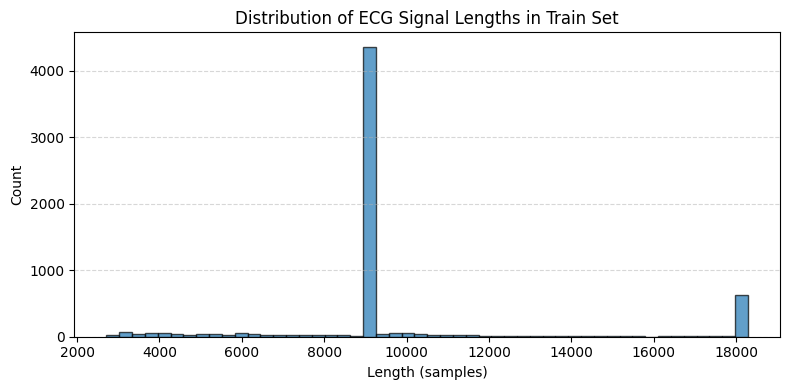

In [43]:
signals = read_binary(train_data_path)
labels  = pd.read_csv(train_label_path, header=None)
summarize_ecg_data(signals, labels)

## Visualizing Class Distribution
We visualize the distribution of ECG signal classes in the dataset using two types of plots: a pie chart and a bar plot. The label_counts dictionary is used to count the occurrences of each class label, and the percentages are calculated to represent the proportion of each class in the dataset.These visualizations help identify any class imbalances in the dataset

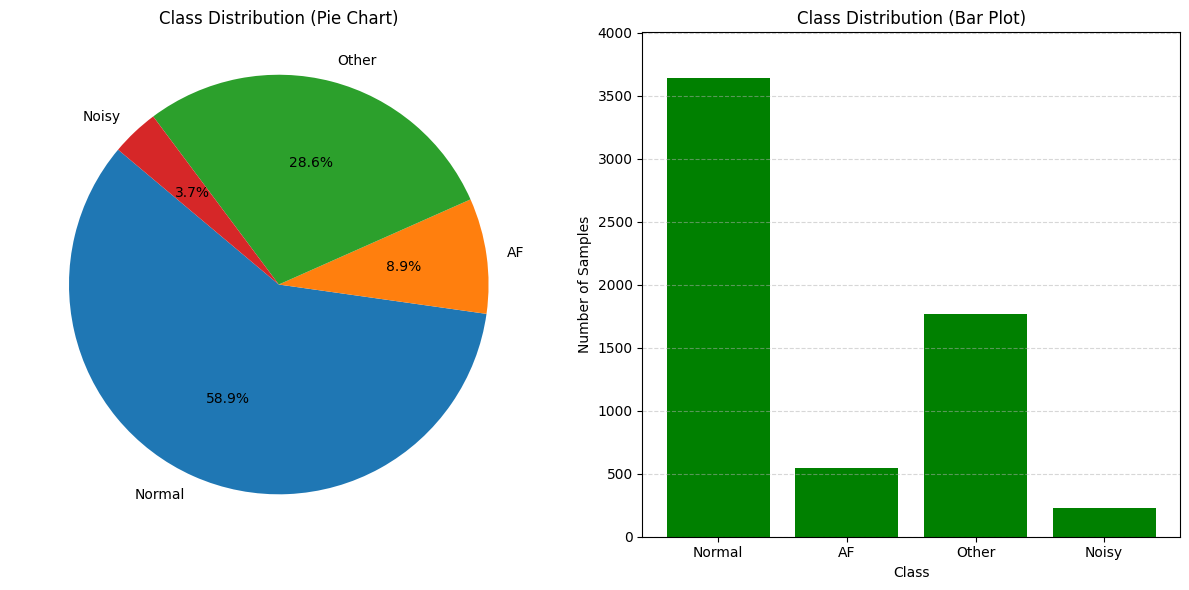

In [44]:
import matplotlib.pyplot as plt


label_counts = {key: 0 for key in label_dict.keys()}
for i in range(len(labels)):
    label = labels.iloc[i, 0] 
    label_counts[label] += 1
    
classes = label_dict.values()
counts = label_counts.values()
total = sum(counts)
percentages = [(count / total) * 100 for count in counts]

# define 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Pie chart
ax1.pie(percentages, labels=classes, autopct='%1.1f%%', startangle=140)
ax1.axis('equal')  
ax1.set_title("Class Distribution (Pie Chart)")
# Bar plot
ax2.bar(classes, counts, color='green')
ax2.set_title("Class Distribution (Bar Plot)")
ax2.set_xlabel("Class")
ax2.set_ylabel("Number of Samples")
ax2.grid(axis='y', linestyle='--', alpha=0.5)
ax2.set_ylim(0, max(counts) * 1.1)


plt.tight_layout()
plt.show()


## Visualizing ECG Signals by Class
We visualize ECG signals for each class by plotting two random samples from each class.This visualization helps in understanding the differences in signal patterns across classes, providing insights into the characteristics of each class.


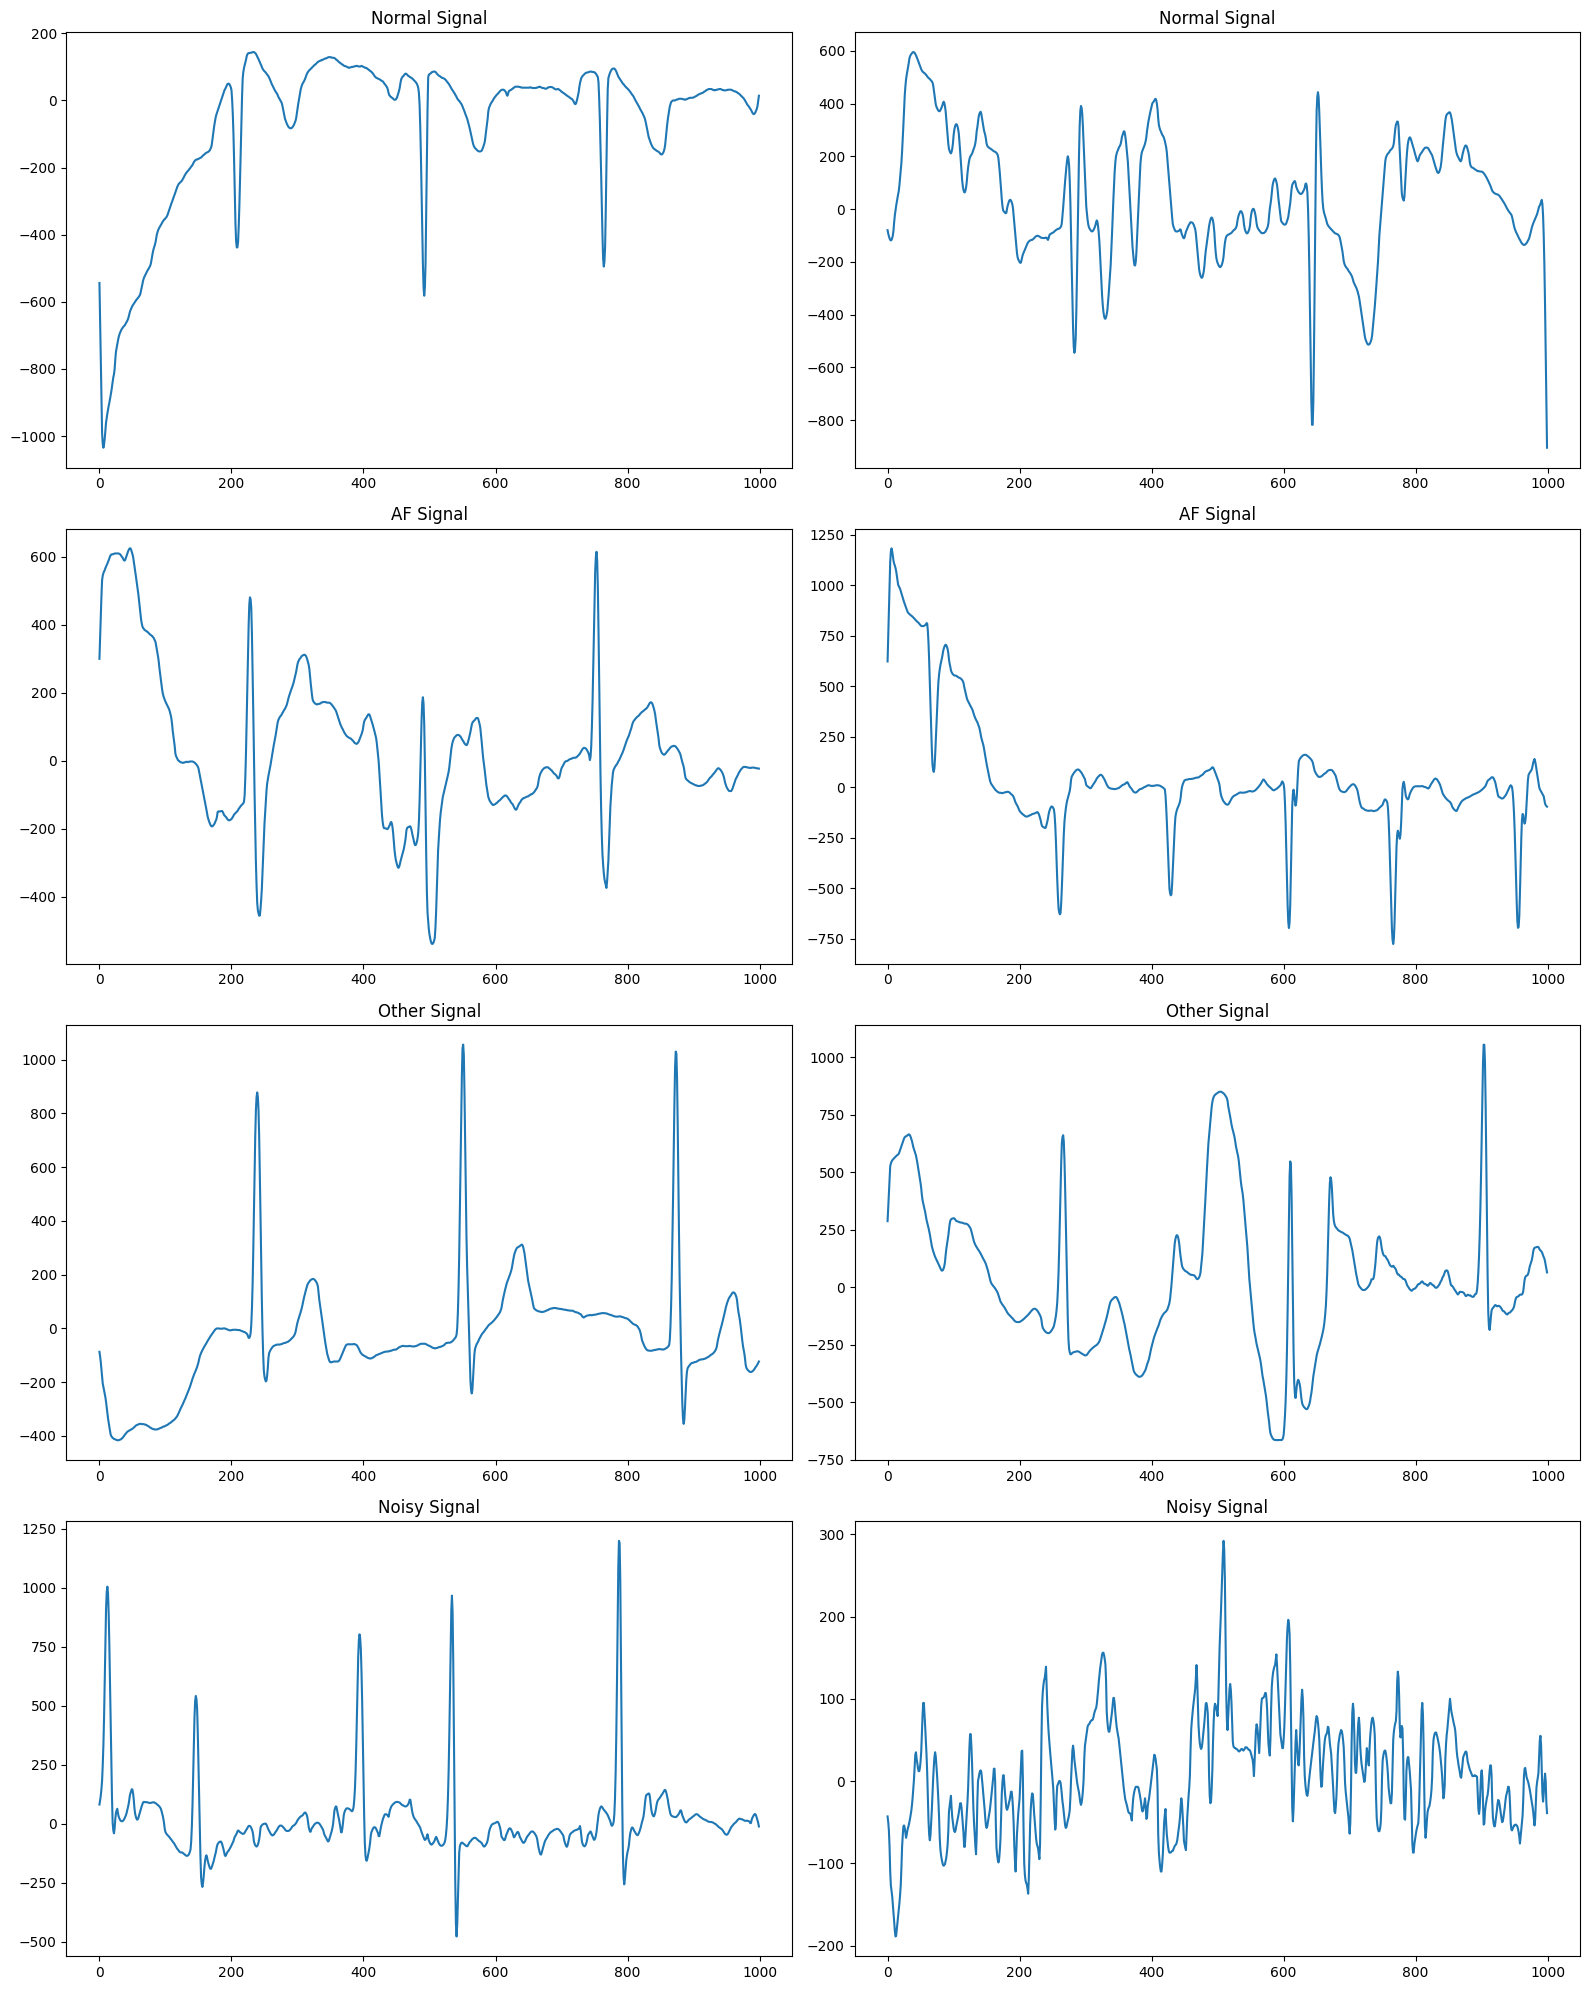

In [45]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, klass in enumerate(label_dict.keys()):
    class_signals = [signal for signal, label in zip(signals, labels.iloc[:, 0]) if label == klass]
    # 2 random samples from each class
    random_signals = random.sample(class_signals, 2)
    for j, signal in enumerate(random_signals):
        axes[2*i+j].plot(signal[:1000])
        axes[2*i+j].set_title(f"{label_dict[klass]} Signal")

plt.tight_layout()
plt.show()

## Creating a DataFrame for ECG Data 
We create a DataFrame to organize the ECG data for further analysis.This structured format makes it easier to perform operations such as grouping, statistical analysis, and visualization on the dataset for further steps in EDA

In [46]:
ecg_df = pd.DataFrame({
    'length': [len(sig) for sig in signals],
    'label': labels[0],
    'signal': signals

})

ecg_df

,length,label,signal
0,9000,2,"[-217, -246, -294, -344, -363, -371, -377, -37..."
1,18000,2,"[-446, -541, -637, -733, -819, -858, -867, -87..."
2,9000,2,"[-440, -527, -614, -698, -770, -790, -796, -79..."
3,9000,0,"[-1255, -1488, -1745, -2015, -2253, -2374, -23..."
4,9000,0,"[156, 189, 223, 255, 291, 330, 362, 380, 390, ..."
...,...,...,...
6174,9000,0,"[546, 588, 632, 679, 696, 673, 605, 536, 512, ..."
6175,9000,0,"[503, 600, 695, 789, 873, 915, 911, 891, 883, ..."
6176,9000,0,"[-339, -412, -490, -566, -618, -632, -642, -64..."
6177,9000,2,"[271, 469, 690, 862, 932, 875, 707, 456, 177, ..."


## Statistics of ECG Signal Lengths by Class
We compute and display descriptive statistics for the lengths of ECG signals grouped by their class labels. This table provides insights into the variability of signal lengths across different classes, which can help identify patterns or anomalies.

In [47]:
stats= ecg_df.groupby('label')['length'].agg([np.mean, np.std, np.min, np.max])
stats = stats.rename(columns={
    'mean': 'Mean Length',
    'std': 'Std Length',
    'amin': 'Min Length',
    'amax': 'Max Length'
})
stats = stats.reset_index()
stats = stats.rename(columns={'label': 'Class'})
stats['Class'] = stats['Class'].map(label_dict)
# .3f format for float values
stats['Std Length'] = stats['Std Length'].map('{:.3f}'.format)
stats['Mean Length'] = stats['Mean Length'].map('{:.3f}'.format)
# add title to the table
new_stats=stats.style.set_caption("Statistics of ECG Signal Lengths by Class")
new_stats


,Class,Mean Length,Std Length,Min Length,Max Length
0,Normal,9662.821,3020.083,2714,18286
1,AF,9510.863,3623.816,2996,18062
2,Other,10366.380,3573.787,2738,18188
3,Noisy,7210.216,2883.541,2808,18000


**Key Observations:**
The average length of the ECG signals differs between classes. In particular, the ‘Noisy’ class has a significantly shorter average length than the other classes. This statistical difference indicates that both the signal structures and data quality of the classes are different.

## Statistics of ECG Signal Values by Class
This code calculates descriptive statistics for the ECG signal values grouped by class.The Dataframe table provides insights into the range and variability of ECG signal values across different classes, which can help identify distinguishing characteristics of each class.

Previously we analyzed the lengths of signals, while here we focus on the intensity of signal values.

In [48]:
class_stats = {}
for label, group in ecg_df.groupby('label'):
    all_signals = np.concatenate(group['signal'].values)
    class_stats[label] = {
        'mean_value': np.mean(all_signals),
        'std': np.std(all_signals),
        'min_value': np.min(all_signals),
        'max_value': np.max(all_signals),
    }

# Print the statistics for each class as dataframe
class_stats_df = pd.DataFrame(class_stats).T
class_stats_df = class_stats_df.rename(columns={
    'mean_value': 'Mean Value',
    'std': 'Std',
    'min_value': 'Min Value',
    'max_value': 'Max Value'
})
class_stats_df = class_stats_df.reset_index()
class_stats_df = class_stats_df.rename(columns={'index': 'Class'})
class_stats_df['Class'] = class_stats_df['Class'].map(label_dict)
# .3f format for float values and int format for min and max values
class_stats_df['Min Value'] = class_stats_df['Min Value'].astype(int)
class_stats_df['Max Value'] = class_stats_df['Max Value'].astype(int)
class_stats_df['Std'] = class_stats_df['Std'].map('{:.3f}'.format)
class_stats_df['Mean Value'] = class_stats_df['Mean Value'].map('{:.3f}'.format)
# add title to the table
new_class_stats_df = class_stats_df.style.set_caption("Statistics of ECG Signal Values by Class")
new_class_stats_df


,Class,Mean Value,Std,Min Value,Max Value
0,Normal,7.777,228.918,-10636,8318
1,AF,8.055,201.118,-6323,6342
2,Other,6.635,234.003,-7360,8257
3,Noisy,5.312,502.394,-7030,7440


**Key Observations:**
- Noisy signals are shorter on average, so unusually short segments might indicate noise. But overall, length alone won’t robustly separate classes. They also have a much higher standard deviation, indicating more volatility. This is a very strong cue for identifying noisy signals.

- Signals are for sure not representative enough. Some of "normal" ECG signals are not normal for example. The figure below and the plot of normal signals above are not always similar. 


## Amplitude Variation by Class (Standard Deviation)

The plot below shows the distribution of the standard deviation of ECG signal amplitudes for each class. The standard deviation indicates how much the amplitude of a signal fluctuates over time.


In [49]:
df=ecg_df.copy()

In [50]:
df['amplitude_mean'] = df['signal'].apply(np.mean)
df['amplitude_std'] = df['signal'].apply(np.std)
df['amplitude_max'] = df['signal'].apply(np.max)
df['amplitude_min'] = df['signal'].apply(np.min)
df['amplitude_range'] = df['amplitude_max'] - df['amplitude_min']


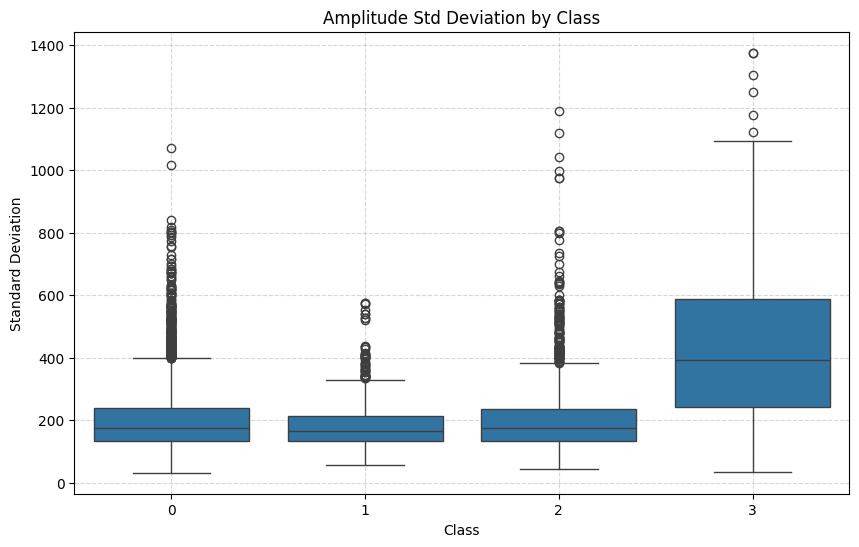

In [51]:
plt.figure(figsize=(10,6))
sns.boxplot(x='label', y='amplitude_std', data=df)
plt.title('Amplitude Std Deviation by Class')
plt.xlabel('Class')
plt.ylabel('Standard Deviation')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


**Key Observations:**
- **Class 3 (Noisy)** signals have significantly higher standard deviation values compared to other classes. Their median is almost twice that of other classes, and some outliers go well beyond 1000.
- **Class 0 (Normal)** and **Class 1 (AF)** signals are relatively stable in amplitude, showing low variation and consistent structure.
- **Class 2 (Other)** displays a wider range, indicating some diversity in rhythm patterns but still lower than noisy signals overall.

The amplitude variability (standard deviation) is a strong candidate for distinguishing **noisy** signals from the rest. A classifier could benefit from using this feature to separate irregular or artifact-heavy recordings.


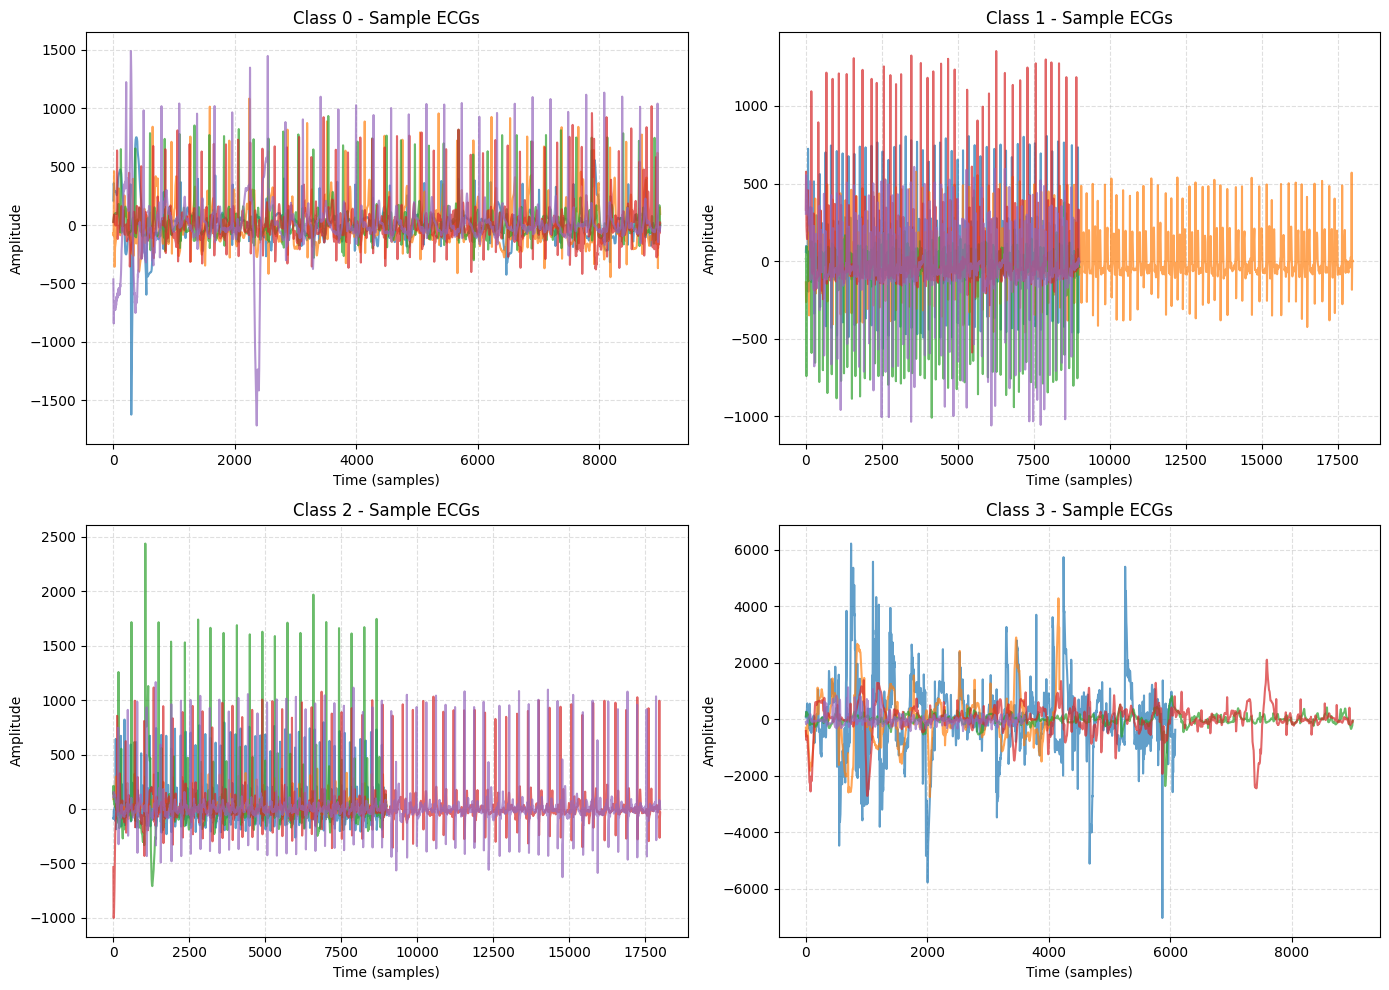

In [52]:
import random
plt.figure(figsize=(14, 10))

# Her sınıftan ayrı subplot
for label in sorted(df['label'].unique()):
    plt.subplot(2, 2, label + 1)
    samples = df[df['label'] == label].sample(n=5, random_state=42)['signal']

    for sig in samples:
        plt.plot(sig, alpha=0.7)

    plt.title(f"Class {label} - Sample ECGs")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


## Visual Patterns / Rhythm

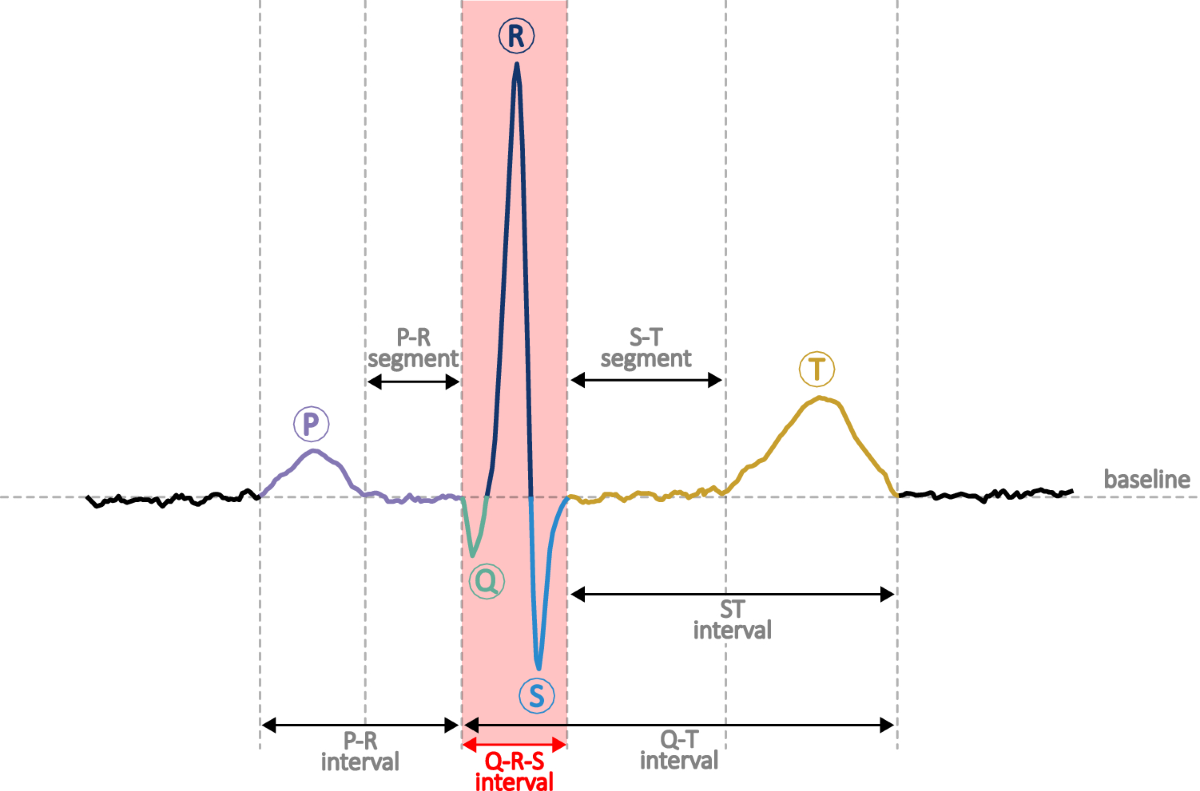


The QRS interval is a distinct part of the ECG waveform that reflects the electrical activity of the ventricles (the main chambers of the heart) as they contract.

The R wave is one of the deflections within the QRS complex. It's the positive (upward) deflection, and it's typically the largest wave in the QRS.

The R peak is simply the highest point of the R wave within the QRS interval.

- Heart Rate Estimate
    -  Count R-peaks, divide by duration in minutes. Get the statistics of this value for each class
- RR Interval Variation
    - Compute the standard deviation of RR intervals over the signal.
   

In [53]:
from scipy.signal import find_peaks # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
from collections import defaultdict # https://docs.python.org/3/library/collections.html#defaultdict-objects

SAMPLING_RATE = 300 # 300 Hz information was given in the task

stats_by_class = defaultdict(list)

for idx, row in ecg_df.iterrows():
    signal = row['signal']
    label = row['label']
    
    # A useful condition for periodic signals can be given with the distance argument.
    # In this case, we can select the positions of QRS complexes within ECG by demanding a distance of at least 150 samples.
    peaks, _ = find_peaks(signal, distance = SAMPLING_RATE * 0.5)
    duration_seconds = len(signal) / SAMPLING_RATE
    heart_rate_bpm = len(peaks) / (duration_seconds / 60)
    
    rr_intervals = np.diff(peaks) / SAMPLING_RATE 
    rr_std_ms = np.std(rr_intervals * 1000) # calculating std in ms for clear values
    
    stats_by_class[label].append((heart_rate_bpm, rr_std_ms))
    
for label in sorted(stats_by_class.keys()):
    data = np.array(stats_by_class[label])
    heart_rates = data[:, 0]
    rr_stds = data[:, 1]

    print(f"\nClass {label_dict[label]}:")
    print(f"  Heart Rate (bpm): mean={heart_rates.mean():.2f}, std={heart_rates.std():.2f}, min={heart_rates.min():.2f}, max={heart_rates.max():.2f}")
    print(f"  RR Std Dev (ms): mean={rr_stds.mean():.2f}, std={rr_stds.std():.2f}, min={rr_stds.min():.2f}, max={rr_stds.max():.2f}")


Class Normal:
  Heart Rate (bpm): mean=78.75, std=8.89, min=60.00, max=106.00
  RR Std Dev (ms): mean=105.06, std=68.17, min=2.40, max=283.32

Class AF:
  Heart Rate (bpm): mean=84.45, std=5.66, min=64.00, max=104.00
  RR Std Dev (ms): mean=142.57, std=33.72, min=19.65, max=265.88

Class Other:
  Heart Rate (bpm): mean=82.88, std=10.58, min=60.00, max=118.00
  RR Std Dev (ms): mean=122.54, std=59.96, min=2.34, max=298.27

Class Noisy:
  Heart Rate (bpm): mean=83.59, std=6.46, min=66.00, max=111.04
  RR Std Dev (ms): mean=150.35, std=32.77, min=27.03, max=227.28


##### Insights

- Heart Rate Estimate
    - There is no striking result here. The values may not be representative for real life values.
- RR Internal Variation
    - AF and Noisy signals have high HRV (Heart Rate Variability) however,

    - AF's HRV is physiological (due to irregular rhythm)

    - Noisy's HRV is likely artifactual (due to poor signal quality)

    - Normal signals tend to cluster around lower HRV, though with some exceptions.

    - RR std dev can be a key feature for distinguishing AF vs Normal
    
    - High HRV + signal quality metric (e.g. signal length) can help distancing AF from Noisy



# Split Strategy

- Compute RR std for each signal.

- Bin samples in that class into quantiles of RR std.

- From each bin, sample proportionally into the validation set (15%).

- Combine validation samples from all classes and bins.

- Ensure no overlap between training and validation sets.

In [54]:
from sklearn.model_selection import train_test_split

def compute_rr_std(signal, fs=SAMPLING_RATE):
    peaks, _ = find_peaks(signal, distance=fs*0.5)
    rr_intervals = np.diff(peaks) * 1000 / fs  # in ms
    return np.std(rr_intervals)

ecg_df['rr_std'] = ecg_df['signal'].apply(lambda x: compute_rr_std(x))

val_indices = []

for label in ecg_df['label'].unique():
    class_df = ecg_df[ecg_df['label'] == label].copy()
    class_df.loc[:, 'rr_bin'] = pd.qcut(class_df['rr_std'], q=4, labels=False, duplicates='drop')
    
    for b in class_df['rr_bin'].unique():
        bin_df = class_df[class_df['rr_bin'] == b]
        val_bin_indices = bin_df.sample(frac=0.15, random_state=42).index
        val_indices.extend(val_bin_indices)

val_df = ecg_df.loc[val_indices]
train_df = ecg_df.drop(index=val_indices)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

Training samples: 5252, Validation samples: 927


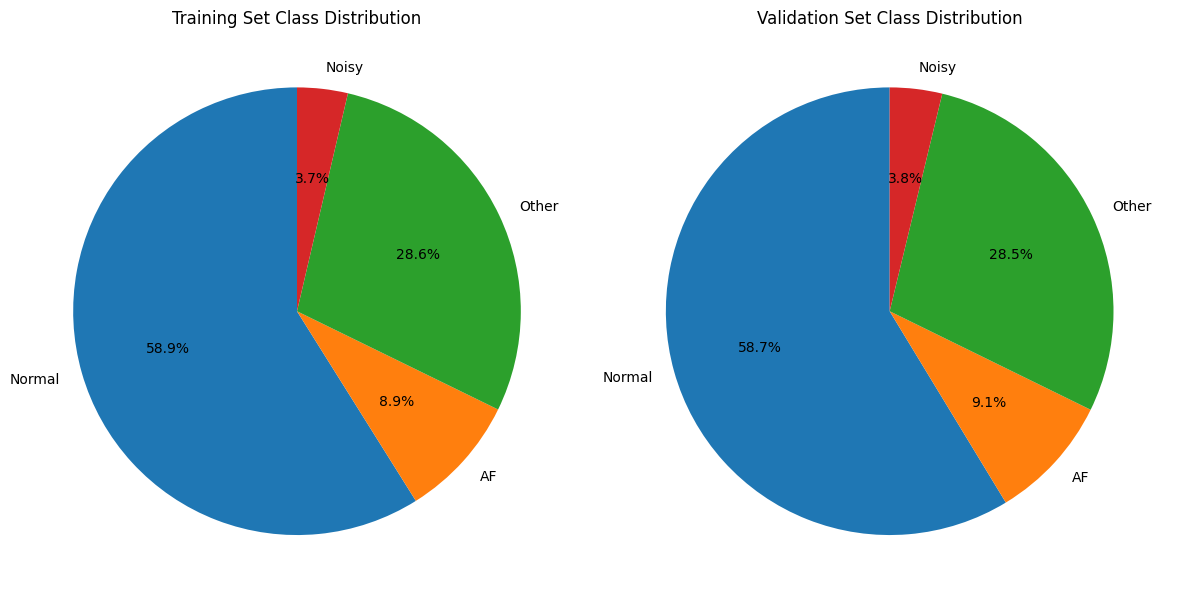

In [55]:
train_counts = train_df['label'].value_counts().sort_index()
val_counts = val_df['label'].value_counts().sort_index()

train_labels = [label_dict[i] for i in train_counts.index]
val_labels = [label_dict[i] for i in val_counts.index]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].pie(train_counts, labels=train_labels, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Training Set Class Distribution')

axs[1].pie(val_counts, labels=val_labels, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Validation Set Class Distribution')

plt.tight_layout()
plt.show()

Our strategy let us creating two sets (train and validation) that has similar class distribution. Also every classes in both sets include various number of samples that have different values for standard deviation of RR interval, also called Hearth Rate Variability.

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Model


In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# STDFT function to compute the Short-Time Fourier Transform (STFT) for a batch of signals
# It convert into time -frequency representation
# n_fft: size of the FFT window(300 hz is the sampling rate, so 256 is a good choice to capture more than 1 heart beat)
# hop_length: number of samples between successive frames (128 is a good choice since every window will overlap by 50%)
def compute_stft_batch(x, n_fft=256, hop_length=128):
    stft = torch.stft(
        x, n_fft=n_fft, hop_length=hop_length,
        return_complex=True
    )
    return torch.abs(stft)  

# 2. Model
class ECGModel(nn.Module):
    def __init__(self):
        super(ECGModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

        # RNN
        self.rnn = nn.GRU(
            input_size=32 * 32, # out_channels * frequency_bins // 2 // 2 (due to max pooling) ()
            hidden_size=128,
            batch_first=True
        )

        # Fully connected
        self.fc = nn.Linear(128, 4)  # 4 classes: Normal, AF, Other, Noisy

    def forward(self, x:torch.Tensor)-> torch.Tensor:
        # x: (batch_size, signal_length)
        #print("Input:", x.shape)
        x = compute_stft_batch(x)  # STFT → (batch, freq, time)
        #print("After STFT:", x.shape)
        x = torch.log1p(x)  # logarithmic scaling
        #print("After log1p:", x.shape)
        

        x = x.unsqueeze(1)  # CNN input shape: (batch, channel, freq, time)
        #print("After Unsqueeze:", x.shape)

        x = self.conv1(x)
        x = self.conv2(x)
        #print("After conv2:", x.shape)

        # Flatten the output for RNN input
        b, c, f, t = x.shape  # batch, channel, freq, time
        x = x.view(b, c * f, t)  # (batch, features, time)
        #print("After view:", x.shape)
        x = x.permute(0, 2, 1)   # (batch, time, features)
        #print("After permute:", x.shape)

        # RNN
        output, h_n = self.rnn(x)
        #print("After RNN output:", output.shape)
        x = self.fc(h_n[-1])  # use the last hidden state for classification
        #print("Final output:", x.shape)
        return x


In [132]:
def pad_or_trim(signal, target_length=9000):
    current_length = len(signal)

    if current_length < target_length:
        # Pad with zeros at the end
        padding = target_length - current_length
        signal = np.pad(signal, (0, padding), 'constant')
    elif current_length > target_length:
        # Trim from center
        start = (current_length - target_length) // 2
        signal = signal[start : start + target_length]

    return signal


In [133]:
from torch.utils.data import Dataset
import torch


class ECGDataset(Dataset):
    def __init__(self, df, target_length=9000):
        self.df = df
        self.target_length = target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Signal processing
        # Pad or trim the signal to the target length
        signal = pad_or_trim(row['signal'], self.target_length)
        signal = torch.tensor(signal, dtype=torch.float32)
        label = int(row['label']) 

        return signal, label


## Data Processing
We use PyTorch's DataLoader to handle the batching and shuffling of ECG data.
This allows efficient training by automatically grouping samples into mini-batches,
converting signals and labels into tensors, and optionally shuffling the training data each epoch.


In [134]:
from torch.utils.data import DataLoader

train_dataset = ECGDataset(train_df)
val_dataset = ECGDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [135]:
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ECGModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [136]:
import torch.utils
import torch.utils.data


def train_one_epoch(model:nn.Module, 
                    dataloader:torch.utils.data.DataLoader, 
                    optimizer:torch.optim.Optimizer, 
                    loss_fn:nn.Module):
    """
    Trains the model for one full epoch.

    Args:
        model: The neural network model (ECGModel).
        dataloader: The training DataLoader providing batches.
        optimizer: The optimizer (e.g., Adam).
        loss_fn: The loss function (e.g., CrossEntropyLoss).

    Returns:
        A tuple of (average_loss, accuracy) for the epoch.
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for signals, labels in dataloader:
        signals = signals.to(device)
        labels = labels.to(device)

        outputs = model(signals)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * signals.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [137]:
def evaluate(model:nn.Module, dataloader:torch.utils.data.DataLoader, loss_fn:nn.Module):
    """
    Evaluates the model on validation data.

    Args:
        model: Trained model to evaluate.
        dataloader: DataLoader for validation data.
        loss_fn: Same loss function used during training.

    Returns:
        A tuple of (average_loss, accuracy) for validation set.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for signals, labels in dataloader:
            signals = signals.to(device)
            labels = labels.to(device)

            outputs = model(signals)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item() * signals.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [138]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np

def evaluate_with_metrics(model:nn.Module, dataloader, loss_fn, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for signals, labels in dataloader:
            signals = signals.to(device)
            labels = labels.to(device)

            outputs = model(signals)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))

    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])
    report = classification_report(
    all_labels, all_preds,
    labels=[0, 1, 2, 3],
    target_names=['Normal', 'AF', 'Other', 'Noisy'],
    zero_division=0  # uyarı vermesin
)

    return avg_loss, acc, f1, cm, report


In [139]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print("-" * 40)


Epoch 1/10
Train Loss: 0.9954 | Train Acc: 0.5807
Val   Loss: 1.0050 | Val   Acc: 0.5868
----------------------------------------
Epoch 2/10
Train Loss: 0.9905 | Train Acc: 0.5889
Val   Loss: 1.0062 | Val   Acc: 0.5868
----------------------------------------
Epoch 3/10
Train Loss: 0.9866 | Train Acc: 0.5891
Val   Loss: 1.0155 | Val   Acc: 0.5868
----------------------------------------
Epoch 4/10
Train Loss: 0.9862 | Train Acc: 0.5891
Val   Loss: 1.0026 | Val   Acc: 0.5868
----------------------------------------
Epoch 5/10
Train Loss: 0.9829 | Train Acc: 0.5891
Val   Loss: 0.9938 | Val   Acc: 0.5868
----------------------------------------
Epoch 6/10
Train Loss: 0.9832 | Train Acc: 0.5891
Val   Loss: 0.9969 | Val   Acc: 0.5868
----------------------------------------
Epoch 7/10
Train Loss: 0.9804 | Train Acc: 0.5891
Val   Loss: 0.9932 | Val   Acc: 0.5890
----------------------------------------
Epoch 8/10
Train Loss: 0.9662 | Train Acc: 0.5904
Val   Loss: 0.9715 | Val   Acc: 0.6041
-

In [140]:
val_loss, val_acc, val_f1, val_cm, val_report = evaluate_with_metrics(model, val_loader, loss_fn, device)

print(f"Validation F1 Score: {val_f1:.4f}")
print("Confusion Matrix:\n", val_cm)
print("Classification Report:\n", val_report)


Validation F1 Score: 0.3113
Confusion Matrix:
 [[489   0  54   1]
 [ 58   0  18   8]
 [197   0  59   8]
 [ 10   0  19   6]]
Classification Report:
               precision    recall  f1-score   support

      Normal       0.65      0.90      0.75       544
          AF       0.00      0.00      0.00        84
       Other       0.39      0.22      0.29       264
       Noisy       0.26      0.17      0.21        35

    accuracy                           0.60       927
   macro avg       0.33      0.32      0.31       927
weighted avg       0.50      0.60      0.53       927



## Class Weight loss

In [148]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Orijinal class weights
original_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2, 3]),
    y=train_df['label'].values
)

# Normalize edip bir tık yumuşatma (0.5x ile scale edelim)
scaled_weights = original_weights / original_weights.max()  # normalize to max=1
scaled_weights = 0.5 + (scaled_weights * 0.5)  # shrink range to [0.5, 1.0] for balance

# Cihaza taşı
weights_tensor = torch.tensor(scaled_weights, dtype=torch.float32).to(device)

# Weighted loss function
loss_fn_weighted = nn.CrossEntropyLoss(weight=weights_tensor)

print("Original weights: ", original_weights)
print("Scaled weights: ", scaled_weights)


Original weights:  [0.42436975 2.82365591 0.87475017 6.83854167]
Scaled weights:  [0.5310278  0.70645161 0.56395736 1.        ]


In [149]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn_weighted)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn_weighted)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print("-" * 40)


Epoch 1/10
Train Loss: 0.8365 | Train Acc: 0.6521
Val   Loss: 0.8409 | Val   Acc: 0.6300
----------------------------------------
Epoch 2/10
Train Loss: 0.8054 | Train Acc: 0.6693
Val   Loss: 0.8119 | Val   Acc: 0.6613
----------------------------------------
Epoch 3/10
Train Loss: 0.7907 | Train Acc: 0.6712
Val   Loss: 0.7914 | Val   Acc: 0.6742
----------------------------------------
Epoch 4/10
Train Loss: 0.7816 | Train Acc: 0.6763
Val   Loss: 0.7721 | Val   Acc: 0.6796
----------------------------------------
Epoch 5/10
Train Loss: 0.7675 | Train Acc: 0.6841
Val   Loss: 0.7821 | Val   Acc: 0.6699
----------------------------------------
Epoch 6/10
Train Loss: 0.7355 | Train Acc: 0.7028
Val   Loss: 0.7672 | Val   Acc: 0.6699
----------------------------------------
Epoch 7/10
Train Loss: 0.7176 | Train Acc: 0.7110
Val   Loss: 0.7658 | Val   Acc: 0.6775
----------------------------------------
Epoch 8/10
Train Loss: 0.7156 | Train Acc: 0.7123
Val   Loss: 0.7911 | Val   Acc: 0.6764
-

In [150]:
val_loss, val_acc, val_f1, val_cm, val_report = evaluate_with_metrics(model, val_loader, loss_fn_weighted, device)

print(f"Validation F1 Score: {val_f1:.4f}")
print("Confusion Matrix:\n", val_cm)
print("Classification Report:\n", val_report)


Validation F1 Score: 0.5220
Confusion Matrix:
 [[473   2  56  13]
 [ 28  14  35   7]
 [131   4 121   8]
 [  5   0   8  22]]
Classification Report:
               precision    recall  f1-score   support

      Normal       0.74      0.87      0.80       544
          AF       0.70      0.17      0.27        84
       Other       0.55      0.46      0.50       264
       Noisy       0.44      0.63      0.52        35

    accuracy                           0.68       927
   macro avg       0.61      0.53      0.52       927
weighted avg       0.67      0.68      0.66       927

